In [1]:
import pandas as pd
from utils.utils import reshample_time_serie

#CCCP_route = r"D:\master BigData\01 proyecto final\datos\IDEAM_ST\prec\tumaco_-78,73-1,82.csv"
IDEAM_route = r"D:\master BigData\01 proyecto final\datos\IDEAM_ST\prec\BUENAVENTURA IDEAM.csv"

serie_ideam = pd.read_csv(IDEAM_route)
# Convierte la columna 'Fecha' a tipo datetime
serie_ideam['Fecha'] = pd.to_datetime(serie_ideam['Fecha'])
# Establece la columna 'Fecha' como el índice
serie_ideam.set_index('Fecha', inplace=True)
# Si el índice ya tiene una zona horaria asociada, usa tz_convert en lugar de tz_localize
serie_ideam.index = serie_ideam.index.tz_localize('UTC').tz_convert('America/Bogota')
serie_ideam.rename(columns={'Valor': 'value'}, inplace=True)

#serie_tumaco = reshample_time_serie(serie_tumaco, 'D', 'sum')

In [2]:
from api_somo import fetch_and_process_data
import numpy as np

api_filtrate_seire = "http://127.0.0.1:8000/database/filter-serie-qf/"
CCCP_fetch = {"station_name": "juanchaco","variable_name": "Precipitación acumulada","processing_level_name": "Control de calidad"}
serie_cccp = fetch_and_process_data(api_filtrate_seire, CCCP_fetch)
serie_cccp.loc[~serie_cccp['qf'].isin([1, 3]), 'value'] = np.nan




Columnas originales: Index(['date_time', 'sensor_data', 'quality_factor__quality_flag'], dtype='object')
Columnas después de renombrar: Index(['timestamp', 'value', 'qf'], dtype='object')


In [3]:
dfs = []

# PREPROCESAMIENTO DE LAS SERIES 
# Renombra la columna de valores a algo único por estación
serie_cccp.rename(columns={"value": 'CCCP'}, inplace=True)
# Agrega el DataFrame a la lista (seleccionando solo la columna renombrada)
dfs.append(serie_cccp[['CCCP']])
# Renombra la columna de valores a algo único por estación
serie_ideam.rename(columns={"value": 'IDEAM'}, inplace=True)
# Agrega el DataFrame a la lista (seleccionando solo la columna renombrada)
dfs.append(serie_ideam[['IDEAM']])

# Combina todas las series temporales usando el índice (timestamp)
data_stations = pd.concat(dfs, axis=1)

# Ordena por el índice (timestamp)
data_stations.sort_index(inplace=True)

# Resultados y estadísticas
print(f"Longitud serie CCCP: {len(serie_cccp)}, y la de IDEAM: {len(serie_ideam)}")
print(f'La tabla general es:\n{data_stations}')


Longitud serie CCCP: 483552, y la de IDEAM: 37726
La tabla general es:
                           CCCP  IDEAM
2013-10-22 05:10:00+00:00   NaN    NaN
2013-10-22 05:20:00+00:00   NaN    NaN
2013-10-22 05:30:00+00:00   NaN    NaN
2013-10-22 05:40:00+00:00   NaN    NaN
2013-10-22 05:50:00+00:00   NaN    NaN
...                         ...    ...
2023-01-01 04:20:00+00:00   0.0    NaN
2023-01-01 04:30:00+00:00   0.0    NaN
2023-01-01 04:40:00+00:00   0.0    NaN
2023-01-01 04:50:00+00:00   0.0    NaN
2023-01-01 05:00:00+00:00   0.0    NaN

[483552 rows x 2 columns]


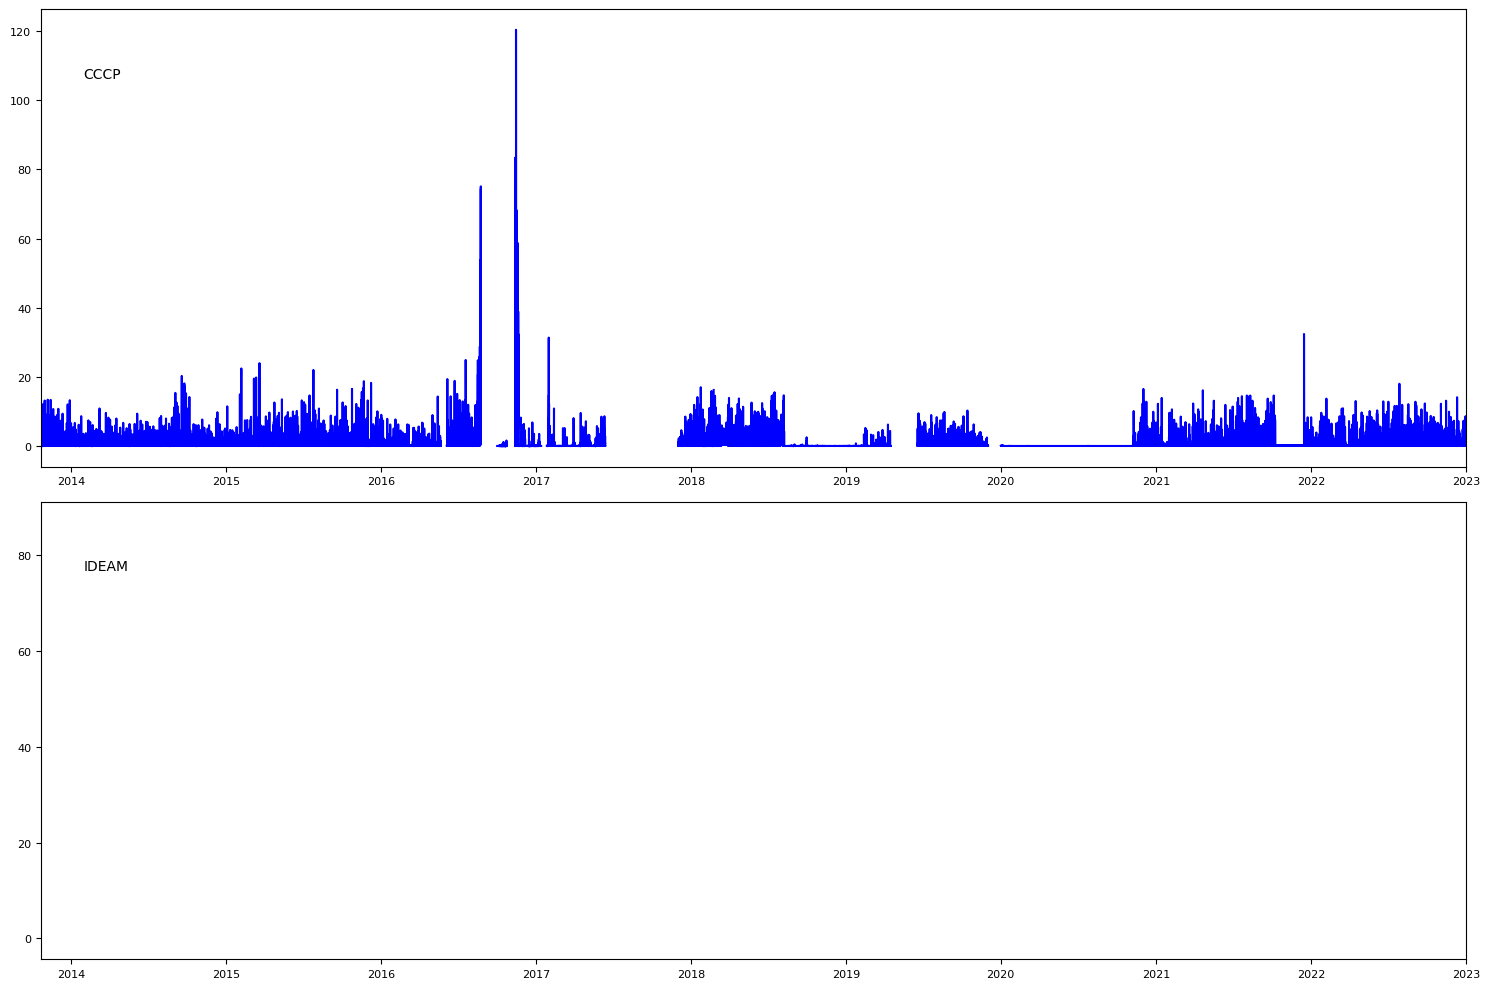

In [4]:
# Gráficar
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=data_stations.shape[1], ncols=1, figsize=(15, 10)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(data_stations.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(data_stations.index, data_stations[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(data_stations.index.min(), data_stations.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=10)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

In [5]:
#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
data_stations.isnull().sum()

CCCP      62916
IDEAM    445826
dtype: int64

CCCP     0
IDEAM    0
dtype: int64
                              CCCP  IDEAM
2016-11-13 00:00:00+00:00   271.22    NaN
2016-11-20 00:00:00+00:00  3898.60    NaN
2016-11-27 00:00:00+00:00    21.65    NaN
2016-12-04 00:00:00+00:00    18.43    NaN
2016-12-11 00:00:00+00:00    14.00    NaN
...                            ...    ...
2021-01-31 00:00:00+00:00     2.90    NaN
2021-02-07 00:00:00+00:00    30.90    NaN
2021-02-14 00:00:00+00:00    10.00    NaN
2021-02-21 00:00:00+00:00    12.60    NaN
2021-02-28 00:00:00+00:00     9.60    NaN

[225 rows x 2 columns]


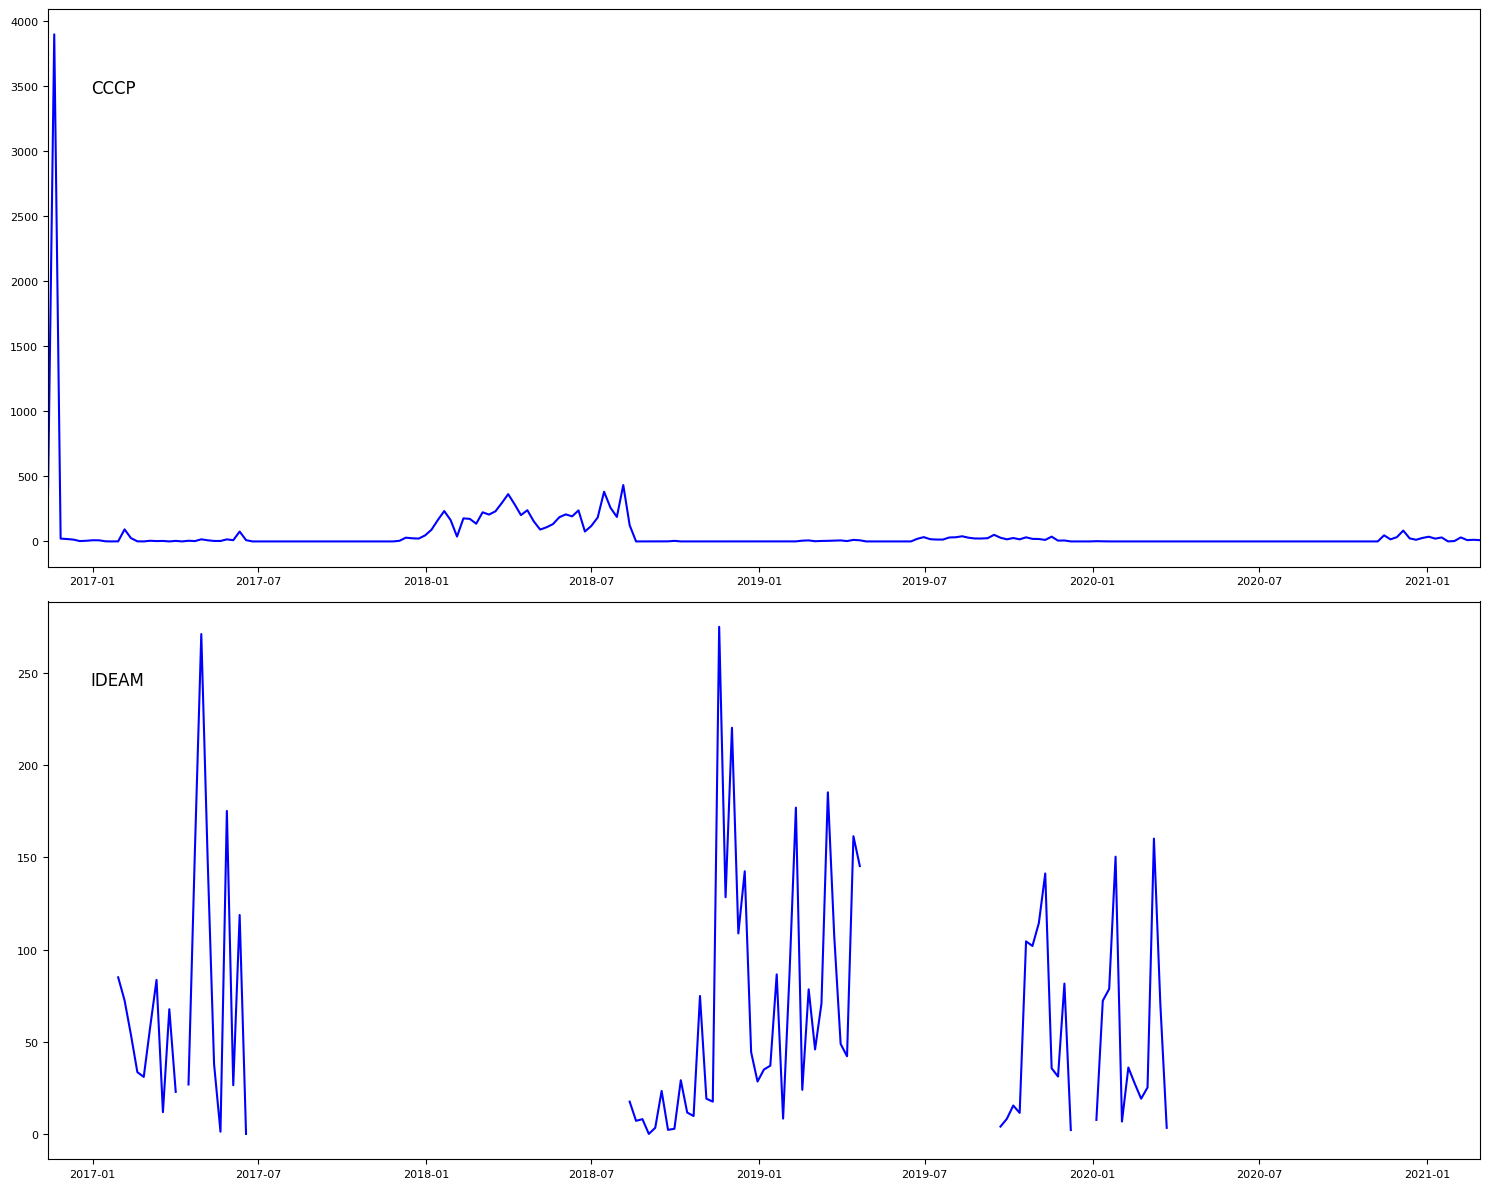

In [6]:
# Crear un dataframe con solo las filas con datos en todas las columnas
estaciones_con_datos = data_stations.dropna()
estaciones_con_datos.shape

#Muestra cuantas celdas con datos nulos o faltantes tiene cada columna de la base de datos
print(estaciones_con_datos.isnull().sum())

#Preprocesamiento de las series 
# remuestreo de serie
estaciones_con_datos = estaciones_con_datos.resample('W').sum()
# Reemplazar valores que no cumplen la condición con NaN
estaciones_con_datos.loc[estaciones_con_datos['IDEAM'] <= 0, 'IDEAM'] = np.nan
print(estaciones_con_datos)


# Gráficar
fig, axs = plt.subplots(nrows=estaciones_con_datos.shape[1], ncols=1, figsize=(15, 12)) # Ajustar el número de "nrows" por el número de columnas a gráficar
for i, col in enumerate(estaciones_con_datos.columns[0:]):
    fila = i
    columna = 0
    ax = axs[fila]
    ax.plot(estaciones_con_datos.index, estaciones_con_datos[col], color='blue')
    ax.set_ylabel('', fontsize=10)
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.set_xlim(estaciones_con_datos.index.min(), estaciones_con_datos.index.max())
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)
plt.subplots_adjust(hspace=0.05)
plt.tight_layout()
plt.show()

,CCCP,IDEAM
CCCP,1.000000,-0.131593
IDEAM,-0.131593,1.000000


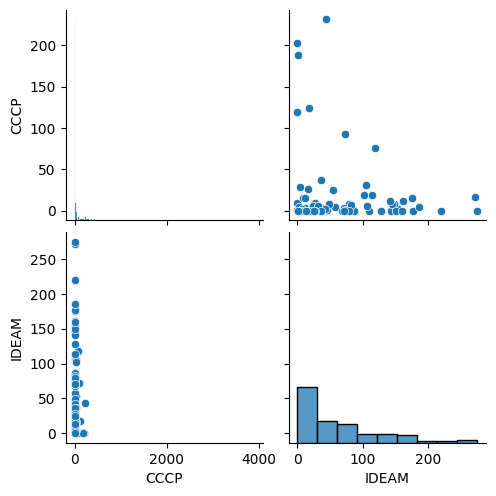

In [7]:
import seaborn as sns 
# Método gráfico de dispersión
sns.pairplot(estaciones_con_datos)
# Metodo numerico
estaciones_con_datos.corr()

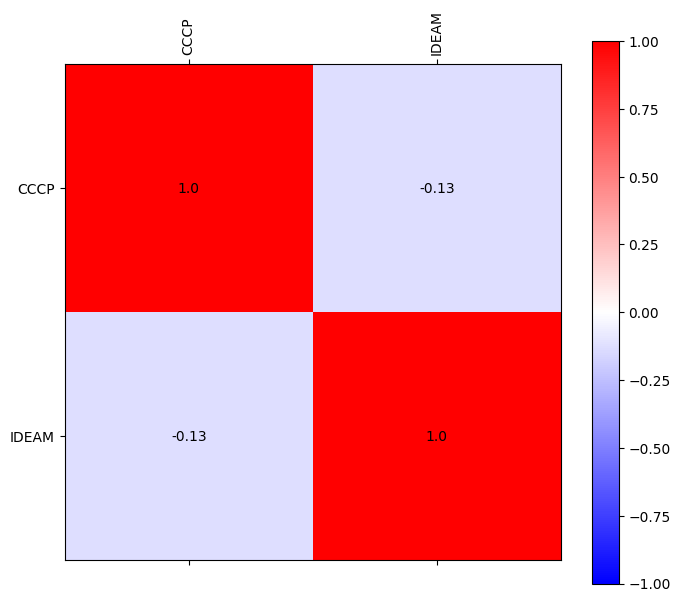

In [8]:
# Calcular la matriz de correlación
matriz = estaciones_con_datos.corr()

# Crear la figura de la matriz de correlación
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)

# Configurar etiquetas de los ejes X e Y
plt.xticks(range(len(matriz.columns)), estaciones_con_datos.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), estaciones_con_datos.columns)

# Agregar los valores de la correlación en cada celda de la matriz
for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2), ha="center", va="center", color="black")

# Agregar barra de colores
plt.colorbar()

# Ajustar el tamaño de la figura
plt.gcf().set_size_inches(8, 7)

# Mostrar la matriz de correlación
plt.show()


# **Completación datos 1**

# **Selecionamos 1 estaciones predictoras y 1 una estación para predecir**

In [9]:
#Organizamos un dataframe con tres estaciones (2 estaciones para ser predictoras y 1 para ser predecida)
data_stations2 = estaciones_con_datos[["CCCP", "IDEAM"]] #ajuste
data_stations2.head(2)
data_stations2.isnull().sum()

CCCP       0
IDEAM    138
dtype: int64

In [10]:
#Solo se dejan las filas que tengan datos en las tres estaciones
fechas_con_datos = data_stations2.dropna() #ajuste
fechas_con_datos.head()

,CCCP,IDEAM
2017-01-29 00:00:00+00:00,0.56,85.0
2017-02-05 00:00:00+00:00,92.52,72.5
2017-02-12 00:00:00+00:00,25.37,53.8
2017-02-19 00:00:00+00:00,0.74,33.6
2017-02-26 00:00:00+00:00,0.00,31.0


Ecuación de la recta: y =  -0.2 x +  64.87
Coeficiente de correlación:  -0.13159282702415398
Coeficiente de determinación:  0.017316672124208732


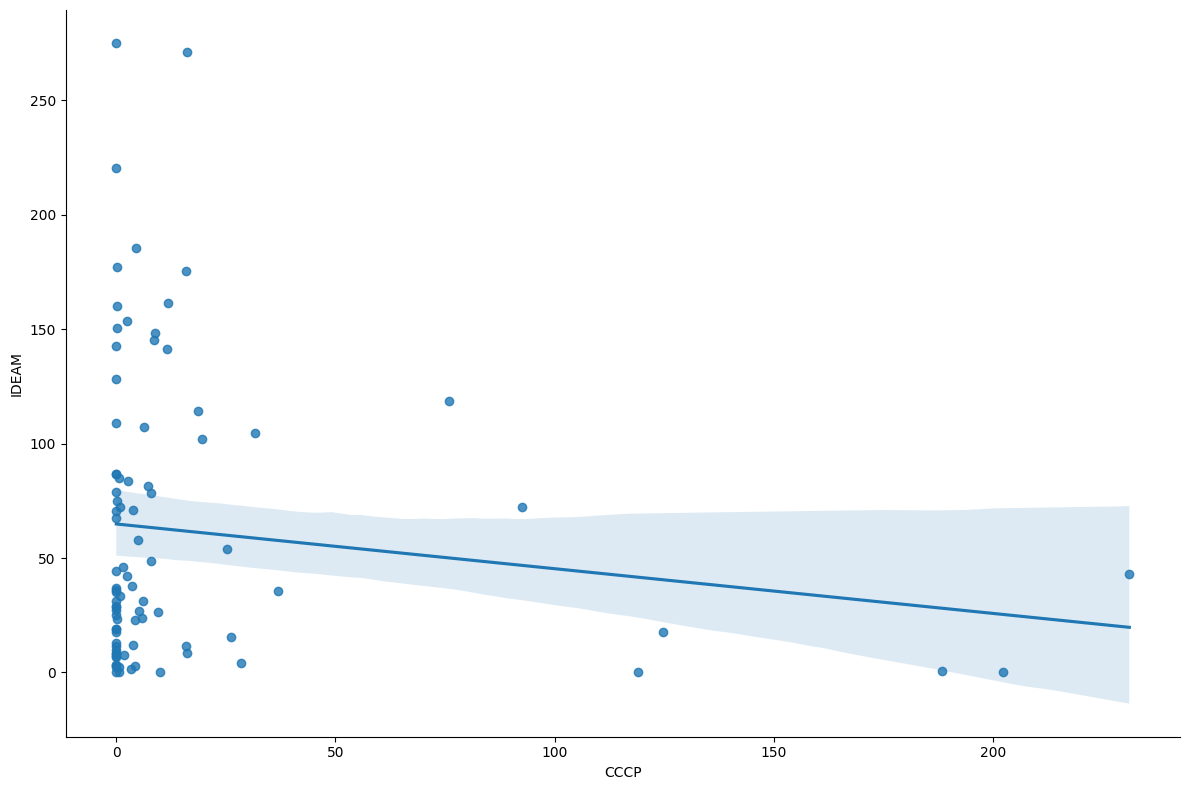

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np
#Gráfico de dispersión 2 variables con centralidad
#predictora = 'IDEAM'
#predecir = 'CCCP'
predictora = 'CCCP'
predecir = 'IDEAM'
modelo = LinearRegression()# generamos la regresión lineal
modelo.fit(fechas_con_datos[[predictora]], fechas_con_datos[predecir])# entrenamos el modelo
print ('Ecuación de la recta: y = ', round(modelo.coef_[0],2),'x + ', round(modelo.intercept_,2))#obtenemos la ecuación de la recta
print ('Coeficiente de correlación: ', np.corrcoef(fechas_con_datos[predictora], fechas_con_datos[predecir])[0,1])#obtenemos el coeficiente de correlación
print ('Coeficiente de determinación: ', r2_score(fechas_con_datos[predecir], modelo.predict(fechas_con_datos[[predictora]])))#obtenemos el coeficiente de determinación
sns.lmplot(x=predictora, y=predecir, data =fechas_con_datos, height=8, aspect=1.5) # Gráfico según variables
plt.show() #Mostrar 

d:\master BigData\01 proyecto final\codigos\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5000) reached and the optimization hasn't converged yet.
  warnings.warn(


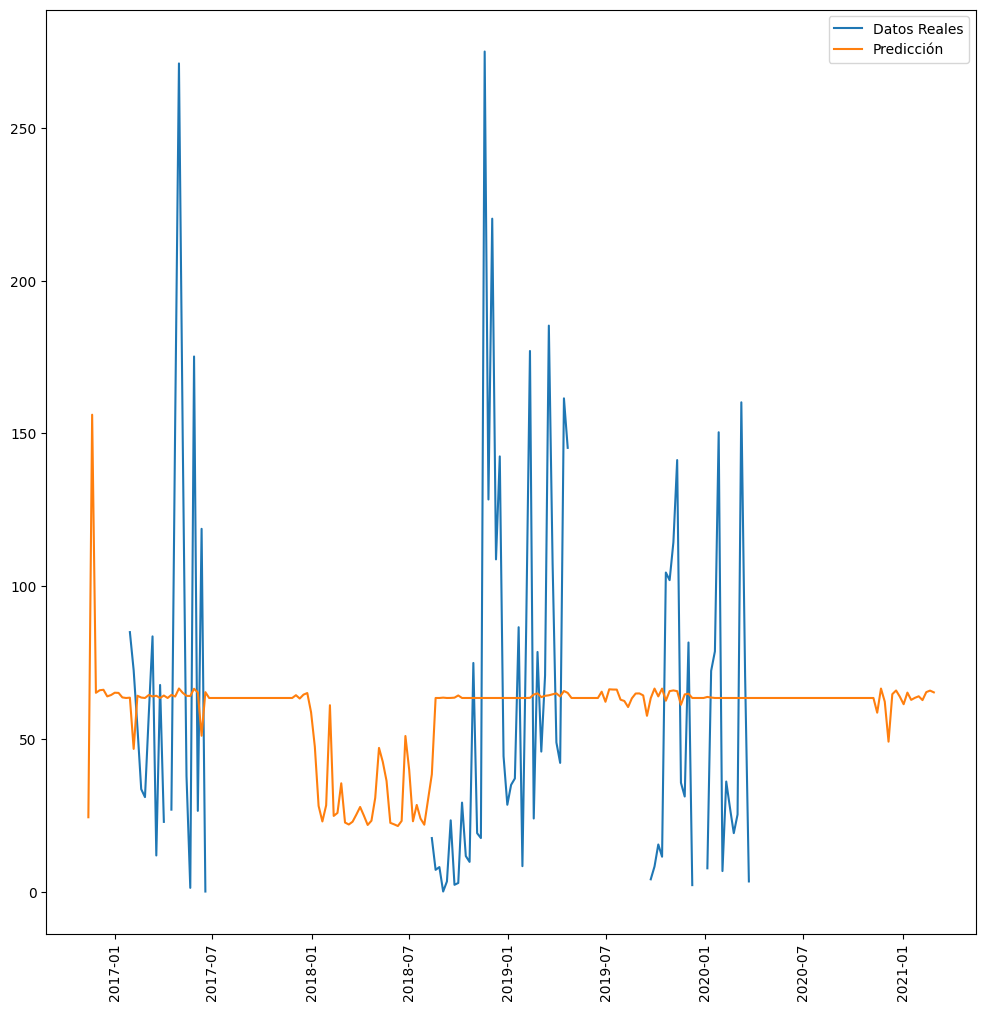

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Datos y variables
# Utiliza solo una variable predictora
xTrain = fechas_con_datos[[predictora]]  # Variable predictora (dataframe con una sola columna)
yTrain = fechas_con_datos[[predecir]].values.flatten()  # Variable a predecir (lista)

# Escalador para estandarizar los datos
scaler = StandardScaler().fit(xTrain.values)
xTrainScaled = scaler.transform(xTrain.values)

# Generar el modelo de regresión de red neuronal
regr = MLPRegressor(random_state=1, max_iter=5000).fit(xTrainScaled, yTrain)

# Datos de prueba
xTest = data_stations2[[predictora]].dropna()  # Utiliza solo la misma variable predictora
xTestScaled = scaler.transform(xTest.values)

# Realizar la predicción
yPredict = regr.predict(xTestScaled)

# Gráfico comparativo de resultados
fig, ax = plt.subplots(figsize=(12, 12), sharex=True, sharey=True)
ax.plot(data_stations2.index, data_stations2[predecir], label='Datos Reales')  # Ajuste real
ax.plot(xTest.index, yPredict, label='Predicción')  # Predicción del modelo
plt.legend()
plt.xticks(rotation='vertical')
plt.show()


In [13]:
# Función para completar valores faltantes
def completar_valores(row):
    if np.isnan(row[predecir]) and ~np.isnan(row[predictora]):
        rowScaled = scaler.transform([[row[predictora]]])
        return regr.predict(rowScaled)[0]
    elif not np.isnan(row[predecir]):
        return row[predecir]
    return np.nan

# Aplicar la función a todo el DataFrame
data_stations2[predecir + '_complet'] = data_stations2.apply(completar_valores, axis=1)



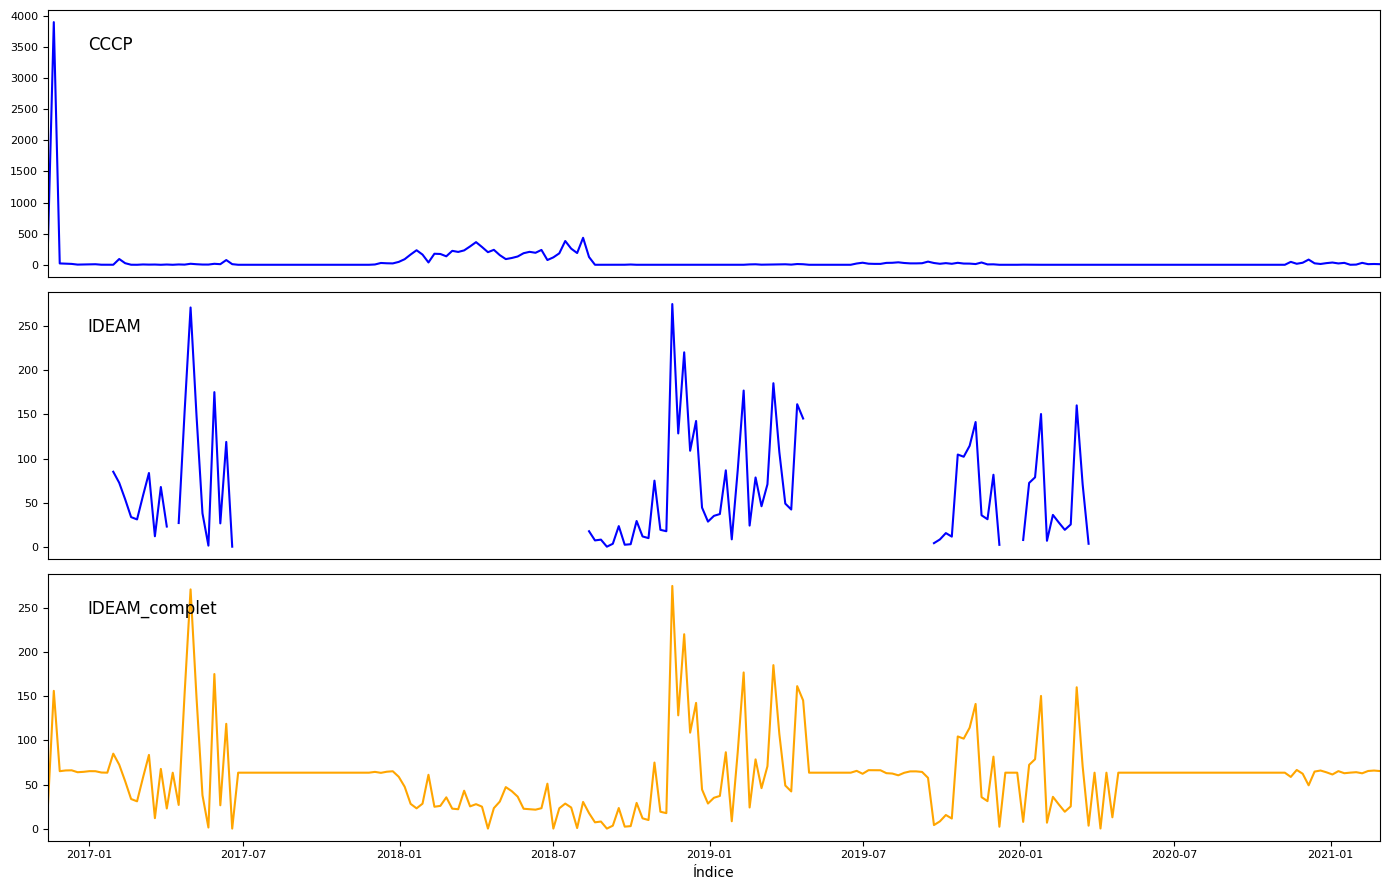

In [14]:
fig, axs = plt.subplots(nrows=len(data_stations2.columns), ncols=1, figsize=(14, 9))
colores = ['blue', 'blue', 'orange', 'red']  # Colores para las líneas

# Iterar sobre las columnas del DataFrame
for i, col in enumerate(data_stations2.columns):  # Enumerar las columnas del DataFrame
    ax = axs[i]  # Seleccionar el subgráfico correspondiente
    ax.plot(data_stations2.index, data_stations2[col], color=colores[i % len(colores)])  # Graficar la columna
    ax.set_ylabel('', fontsize=10)  # Etiqueta del eje Y (puedes personalizar)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Ajustar el tamaño de las etiquetas
    ax.set_xlim(data_stations2.index.min(), data_stations2.index.max())  # Limitar el eje X a los valores disponibles
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)  # Añadir el nombre de la columna en cada subgráfico

    # Ocultar etiquetas del eje X para los gráficos excepto el último
    if i != len(data_stations2.columns) - 1:
        ax.set_xticks([])
    else:
        ax.set_xlabel('Índice', fontsize=10)  # Etiqueta del eje X en el último gráfico

# Ajustar espacio entre gráficos
plt.subplots_adjust(hspace=0.1)
plt.tight_layout()
plt.show()


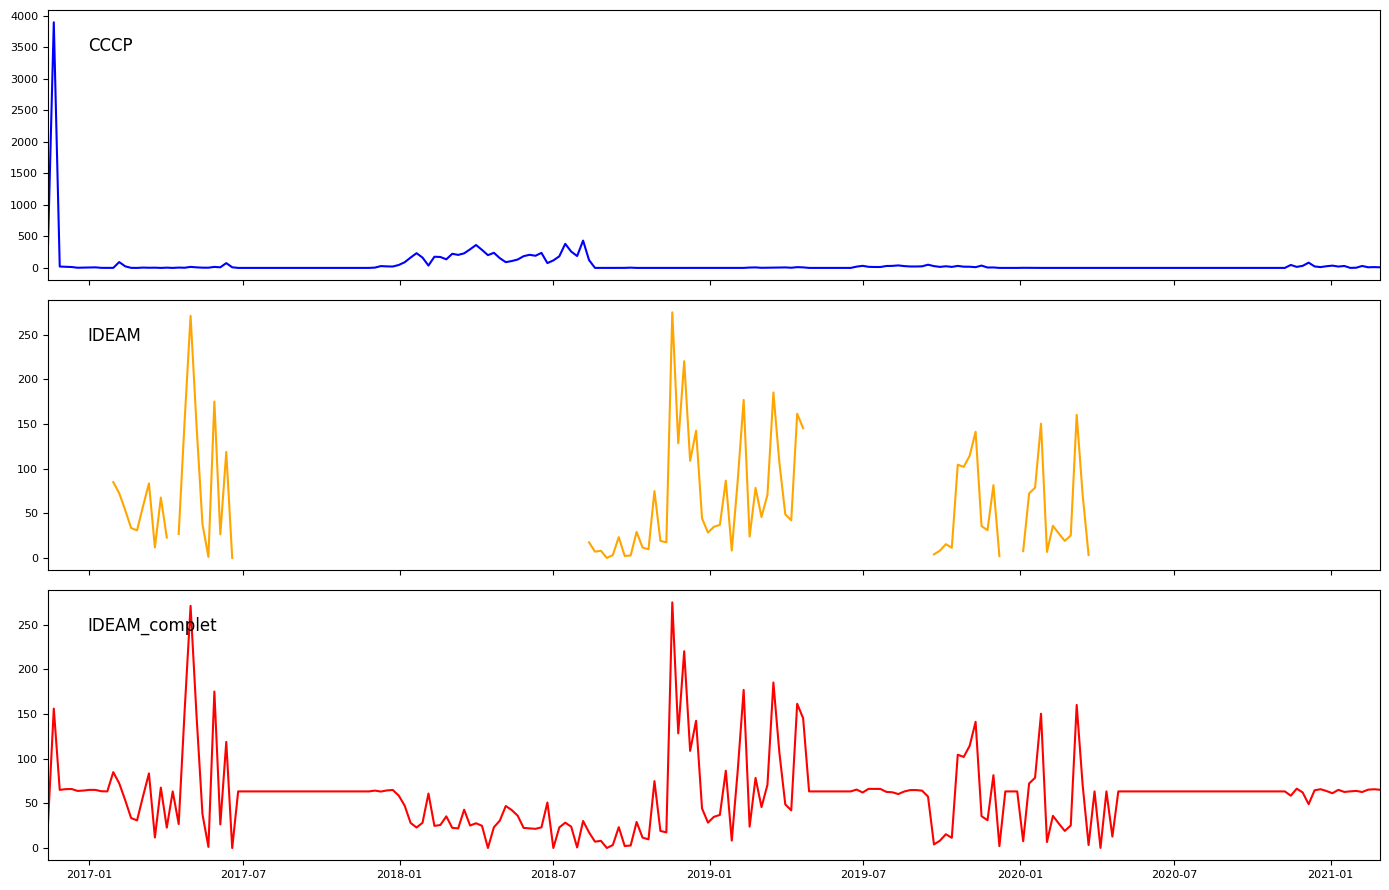

In [15]:
import matplotlib.pyplot as plt

# Crear subgráficos dinámicos según el número de columnas
fig, axs = plt.subplots(nrows=len(data_stations2.columns), ncols=1, figsize=(14, 9), sharex=True)

# Lista de colores para las líneas
colores = ['blue', 'orange', 'red', 'green']

# Manejo de subgráficos si solo hay una columna
if len(data_stations2.columns) == 1:
    axs = [axs]
print(enumerate(data_stations2.columns))
# Iterar sobre las columnas del DataFrame
for i, col in enumerate(data_stations2.columns):
    ax = axs[i]  # Seleccionar el subgráfico correspondiente
    ax.plot(data_stations2.index, data_stations2[col], color=colores[i % len(colores)], label=col)
    ax.set_ylabel('', fontsize=10)  # Etiqueta del eje Y (puedes personalizar)
    ax.tick_params(axis='both', which='major', labelsize=8)  # Ajustar el tamaño de las etiquetas
    ax.set_xlim(data_stations2.index.min(), data_stations2.index.max())  # Limitar el eje X a los valores disponibles
    ax.text(0.03, 0.85, col, transform=ax.transAxes, fontsize=12)  # Añadir el nombre de la columna en cada subgráfico


# Ajustar espacio entre gráficos
plt.subplots_adjust(hspace=0.3)  # Incremento del espacio entre gráficos para mayor claridad
plt.tight_layout()
plt.show()


In [16]:
from graphics_utils.go import multi_line
fig = multi_line(CCCP=data_stations2['CCCP'], Imputadas=data_stations2['IDEAM_complet'], IDEAM=data_stations2['IDEAM'])
fig.show()

In [17]:
# Redondear la columna y reasignarla al DataFrame
data_stations2['IDEAM_complet'] = data_stations2['IDEAM_complet'].round()
data_stations2.isnull().sum()
# Formatear las fechas del índice
data_stations2.index = data_stations2.index.strftime('%Y-%m-%d')
# Guardar en un archivo CSV con el índice y un nombre específico para el índice
data_stations2[['IDEAM_complet']].to_csv('tumaco_ideam_remaster1.csv', index=True, index_label='Fecha')

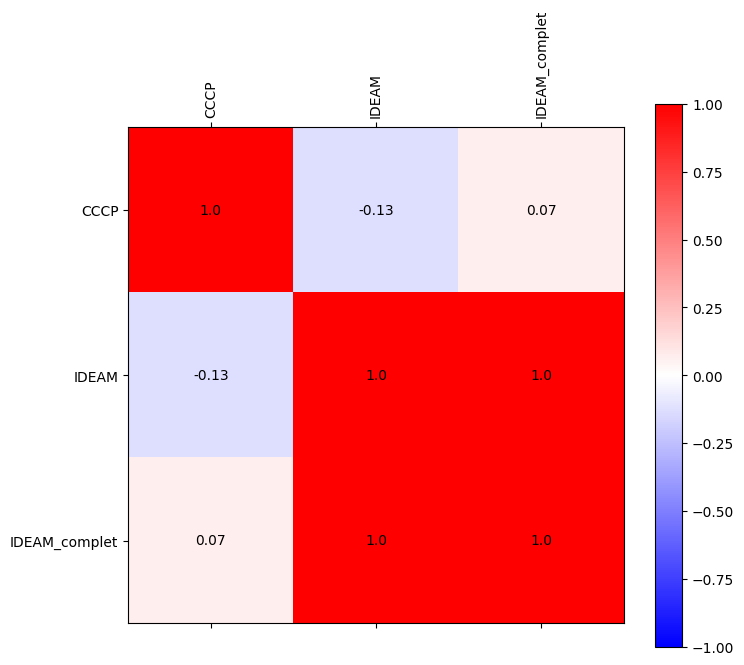

In [18]:
# Calcular la matriz de correlación
matriz = data_stations2.corr()

# Crear la figura de la matriz de correlación
plt.matshow(matriz, cmap="bwr", vmin=-1, vmax=1)

# Configurar etiquetas de los ejes X e Y
plt.xticks(range(len(matriz.columns)), data_stations2.columns, rotation=90)
plt.yticks(range(len(matriz.columns)), data_stations2.columns)

# Agregar los valores de la correlación en cada celda de la matriz
for i in range(len(matriz.columns)):
    for j in range(len(matriz.columns)):
        plt.text(i, j, round(matriz.iloc[i, j], 2), ha="center", va="center", color="black")

# Agregar barra de colores
plt.colorbar()

# Ajustar el tamaño de la figura
plt.gcf().set_size_inches(8, 7)

# Mostrar la matriz de correlación
plt.show()
